In [2]:
import numpy as np
import nibabel as nb
import SimpleITK as sitk
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from loguru import logger
import sys
import maximum_expectation_algorithm
import random

In [3]:
def print_shapes(data,name):
    """
    Print the shapes of all white matter (WM) tissue images.

    :param wm_data: List of white matter (WM) brain images.
    """
    for idx, image in enumerate(data):
        print(f"Shape of {name} image {idx + 1}: {image.shape}")

In [4]:

root_dir = '../Register_testing_volumes/mni_atlas_REGISTERED_AFFINE10/'

# Get all .nii.gz files recursively from the root directory
all_nii_files = glob.glob(os.path.join(root_dir, '102*', '*.nii'), recursive=True)

# Categorize files by type
file_categories = {
    'mni_atlas_1C': [],
    'mni_atlas_p_atlas_background': [],
    'mni_atlas_p_atlas_csf': [],
    'mni_atlas_p_atlas_gm': [],
    'mni_atlas_p_atlas_wm': [],
    'mni_atlas_template': []
    }

for file in all_nii_files:
    for category in file_categories.keys():
        if category in os.path.basename(file):
            file_categories[category].append(file)

# Load the files for each category (example shown for one category)
number_of_brains = 15
brain_layer = 127

# Check file paths (add this for debugging)
print(f"Found mni_atlas_1C files: {file_categories['mni_atlas_1C'][:number_of_brains]}")
print(' ')
# Load the files for each category using simpleITK
mni_atlas_p_atlas_background = [sitk.GetArrayFromImage(sitk.ReadImage(file)) for file in file_categories['mni_atlas_p_atlas_background'][:number_of_brains]]
mni_atlas_p_atlas_csf = [sitk.GetArrayFromImage(sitk.ReadImage(file)) for file in file_categories['mni_atlas_p_atlas_csf'][:number_of_brains]]
mni_atlas_p_atlas_gm = [sitk.GetArrayFromImage(sitk.ReadImage(file)) for file in file_categories['mni_atlas_p_atlas_gm'][:number_of_brains]]
mni_atlas_p_atlas_wm = [sitk.GetArrayFromImage(sitk.ReadImage(file)) for file in file_categories['mni_atlas_p_atlas_wm'][:number_of_brains]]
mni_atlas_p_atlas_mask = [sitk.GetArrayFromImage(sitk.ReadImage(file)) for file in file_categories['mni_atlas_p_atlas_background'][:number_of_brains]]

t1 = sitk.ReadImage(os.path.join('..', 'Register_testing_volumes','test','test','testing-images', '1025.nii.gz'))
t1_array = sitk.GetArrayFromImage(t1)
t1_mask = sitk.ReadImage(os.path.join('..', 'Register_testing_volumes','test','test','testing-mask', '1025_1C.nii.gz'))
t1_mask = sitk.GetArrayFromImage(t1_mask)

# Stack and process the data as needed
logger.success(f'Imported {len(mni_atlas_p_atlas_csf)} mni_atlas_p_atlas_csf images')
logger.success(f'Imported {len(mni_atlas_p_atlas_gm)} mni_atlas_p_atlas_csf images')
logger.success(f'Imported {len(mni_atlas_p_atlas_wm)} mni_atlas_p_atlas_csf images')
logger.success(f'Imported {len(mni_atlas_p_atlas_mask)} mni_atlas_p_atlas_mask images')

# For debuggig
print_shapes(mni_atlas_p_atlas_mask,'WM')


Found mni_atlas_1C files: ['../Register_testing_volumes/mni_atlas_REGISTERED_AFFINE10/1025/mni_atlas_1C.nii', '../Register_testing_volumes/mni_atlas_REGISTERED_AFFINE10/1023/mni_atlas_1C.nii', '../Register_testing_volumes/mni_atlas_REGISTERED_AFFINE10/1024/mni_atlas_1C.nii']
 


2023-11-24 20:25:14.746 | SUCCESS  | __main__:<module>:41 - Imported 3 mni_atlas_p_atlas_csf images
2023-11-24 20:25:14.747 | SUCCESS  | __main__:<module>:42 - Imported 3 mni_atlas_p_atlas_csf images
2023-11-24 20:25:14.747 | SUCCESS  | __main__:<module>:43 - Imported 3 mni_atlas_p_atlas_csf images
2023-11-24 20:25:14.748 | SUCCESS  | __main__:<module>:44 - Imported 3 mni_atlas_p_atlas_mask images


Shape of WM image 1: (256, 312, 256)
Shape of WM image 2: (256, 319, 256)
Shape of WM image 3: (256, 289, 256)


In [5]:
stacked_data = np.stack([mni_atlas_p_atlas_csf[0],mni_atlas_p_atlas_gm[0],mni_atlas_p_atlas_wm[0]],axis=0)
print(stacked_data.shape)

(3, 256, 312, 256)


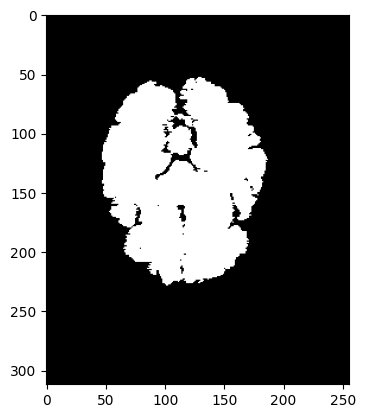

In [6]:

# Assuming t1_mask and t1 are predefined NumPy arrays
# Create a brain mask
brainmask = np.where(t1_mask != 0, 255, 0).astype('uint8')

# If you want to apply the mask and keep the original shape

t1_masked = np.where(brainmask == 255, t1_array, 0)
masked_stack = np.zeros_like(stacked_data)

# Apply the mask to each volume/timepoint
for i in range(masked_stack.shape[0]):
    masked_stack[i] = np.where(brainmask == 255, masked_stack[i], 0)
# Choose a layer to display
brain_layer = 127# Adjust this based on your data

# Plot the chosen layer
plt.imshow(t1_mask[brain_layer, :, :], cmap='gray')
plt.show()

# Print unique values in the


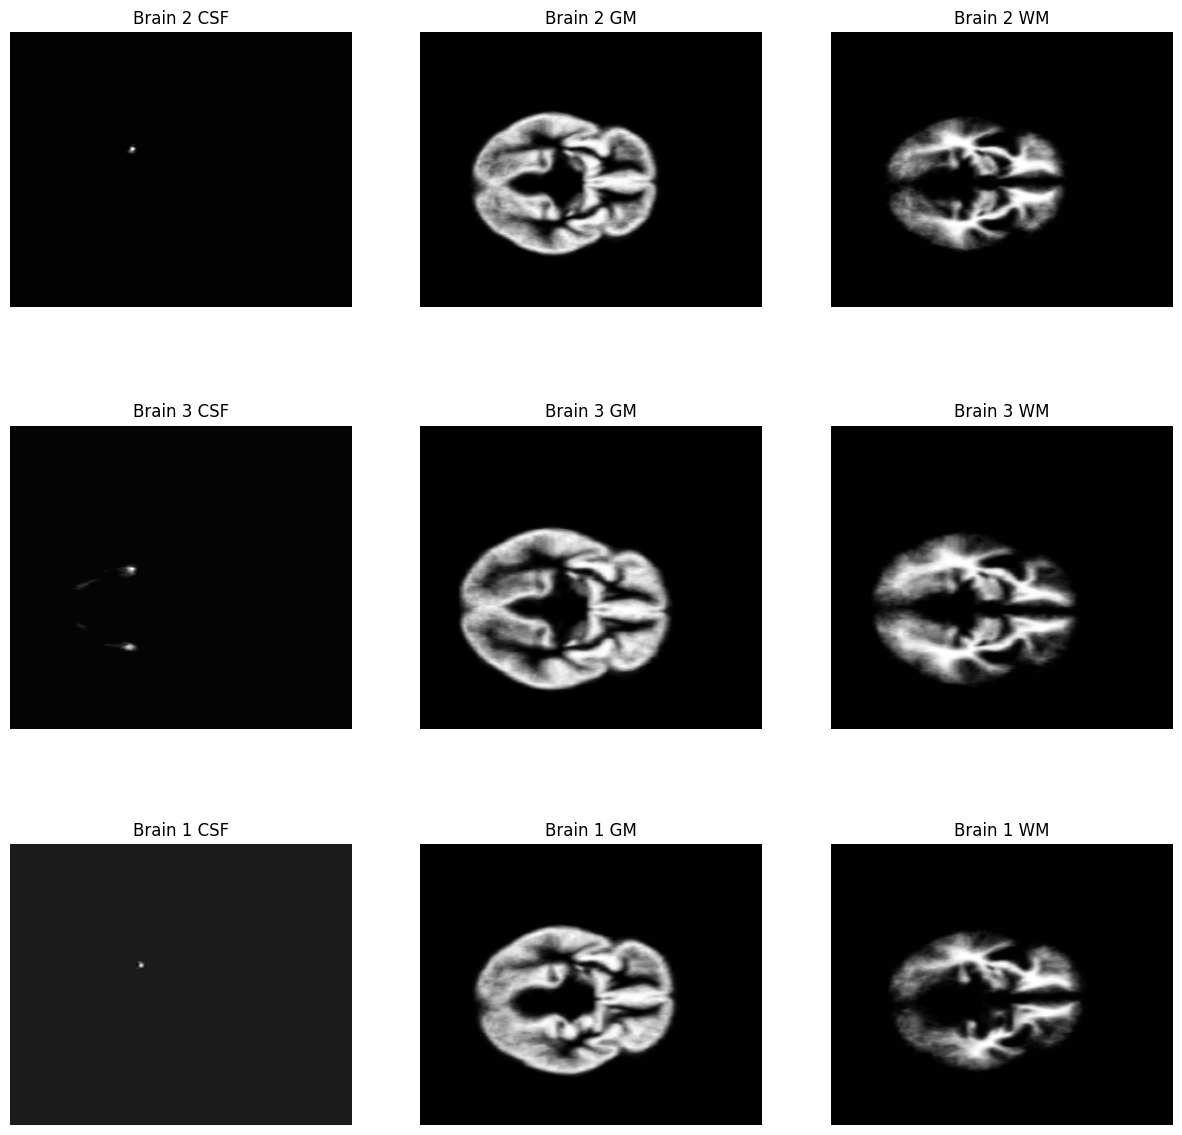

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_different_brains_rotated(csf_data, gm_data, wm_data, layer):
    """
    Plot specific brain layers from three different brains for each tissue type,
    with each image rotated by 90 degrees.
    
    :param csf_data: List of cerebrospinal fluid (CSF) brain images.
    :param gm_data: List of gray matter (GM) brain images.
    :param wm_data: List of white matter (WM) brain images.
    :param layer: Specific layer of the brain to plot.
    """
    # Randomly select three different brains for each tissue type
    brains_indices = random.sample(range(len(csf_data)), 3)

    # Plotting
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, idx in enumerate(brains_indices):
        axes[i, 0].imshow(np.rot90(csf_data[idx][layer, :, :]), cmap='gray')
        axes[i, 0].set_title(f'Brain {idx+1} CSF')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.rot90(gm_data[idx][layer, :, :]), cmap='gray')
        axes[i, 1].set_title(f'Brain {idx+1} GM')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(np.rot90(wm_data[idx][layer, :, :]), cmap='gray')
        axes[i, 2].set_title(f'Brain {idx+1} WM')
        axes[i, 2].axis('off')

    plt.show()

# Example usage of the function
plot_different_brains_rotated(mni_atlas_p_atlas_csf, mni_atlas_p_atlas_gm, mni_atlas_p_atlas_wm, brain_layer)


In [7]:
# Initialize an empty list to store the segmented images
probmaps = []

# Assuming mni_atlas_p_atlas_csf, mni_atlas_p_atlas_gm, mni_atlas_p_atlas_wm are 3D arrays
# Iterate over each slice/index
for i in range(len(mni_atlas_p_atlas_csf)):  # Adjust according to the number of slices
    # Stack the probability maps for this slice
    prob_map = np.stack((mni_atlas_p_atlas_csf[i], mni_atlas_p_atlas_gm[i], mni_atlas_p_atlas_wm[i]), axis=-1)


In [8]:
EM = maximum_expectation_algorithm.maximum_expectation_algorithm()

In [9]:
ll=stacked_data.reshape(-1,stacked_data.shape[0])
print(ll.shape)

(20447232, 3)


In [10]:
tpm_mni = np.where(stacked_data > 1, 1, stacked_data)
tpm_mni = np.where(tpm_mni < 0, 0, tpm_mni)

t1 = EM.min_max_normalization(t1_array)

t1_segmentation, t1_segmentation_time = EM.tissue_segmentation(t1,t1_mask,type='label_propragation',label_pro=stacked_data)

T1: Expectation Maximination in progress with label_propragation init: 100%|█| 1


(256, 312, 256)
[0 1 2 3]


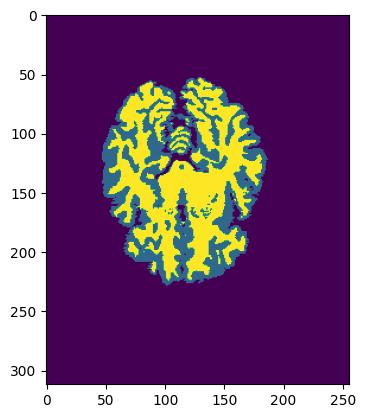

In [12]:
print(t1_segmentation.shape)
plt.imshow(t1_segmentation[brain_layer,:,:])
print(np.unique(t1_segmentation))

In [10]:
data=t1_array.flatten()

In [12]:
print(data.shape)

(20447232,)


In [20]:
print(data.shape)

(20447232,)


In [42]:
tm = np.load('tissue_models.npy')
print(tm[1:,:].shape)  
T = tm[1:,:]
print(T[0,254])

(3, 255)
0.0


In [24]:
print(np.unique(data))

[0.000e+00 1.000e+00 2.000e+00 ... 4.179e+03 4.211e+03 4.238e+03]
